# Set up

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Exercise: *Use t-SNE to reduce the first 5,000 images of MNIST dataset down to 2 dimensions and plot the result using Matplotlib. You can use a scatter plot using 10 different colors to represent each images's target class* 

In [27]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False, parser="auto")

In [28]:
X_sample = mnist.data[:5000]
y_sample = mnist.target[:5000]

In [29]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=42)
%time 
X_reduced = tsne.fit_transform(X_sample)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 13.8 µs


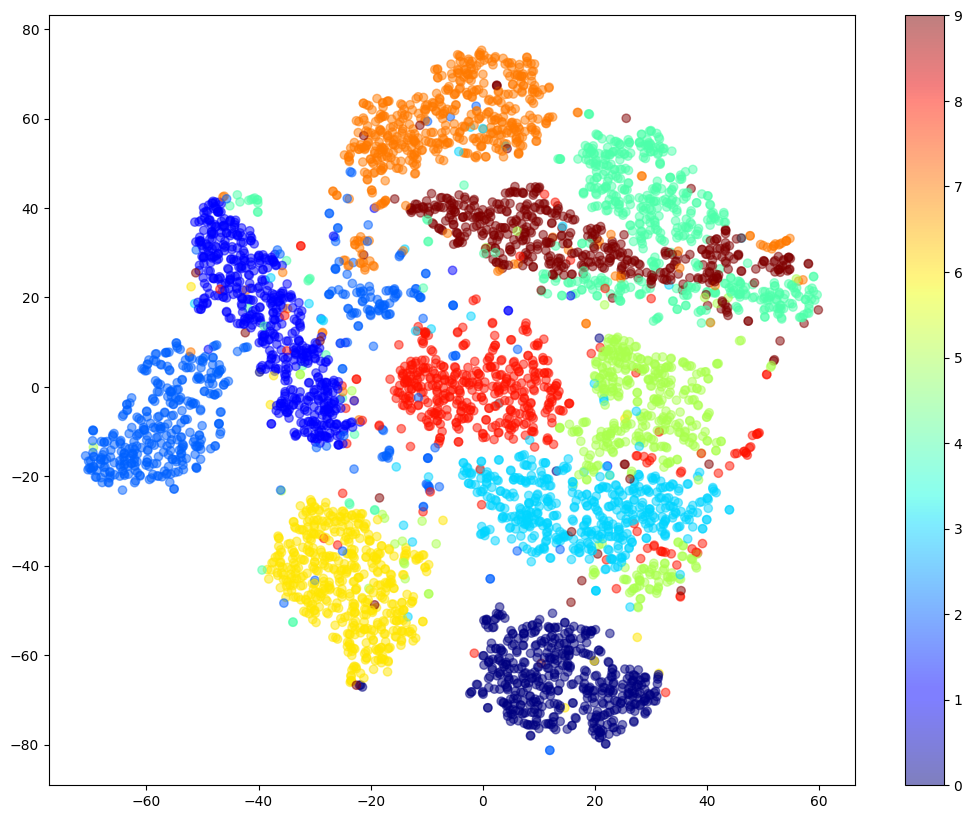

In [30]:
plt.figure(figsize=(13, 10))
plt.scatter(
    X_reduced[:, 0], X_reduced[:, 1], c=y_sample.astype(np.int8), cmap="jet", alpha=0.5
)
plt.colorbar()
plt.show()

This plot explains a lot! Most digits are well separated form each other, even though t-SNE doesn't give us the target, it just gives us the clusters of similar images. For example, the 3s and 5s overlap quite a bit (on the middle right part of the plot), and so do 4s and 9s (on the top-right).

Now let's focus at the digits 4 and 9.

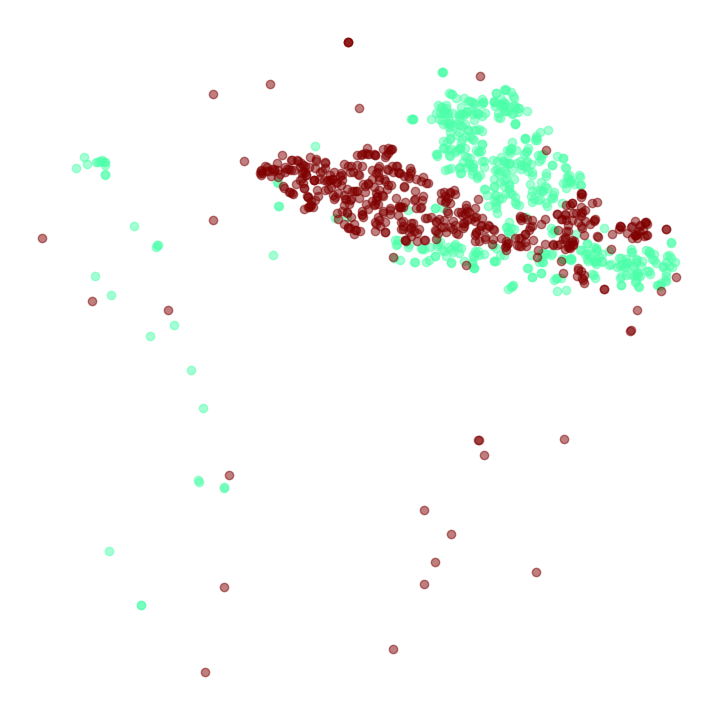

In [31]:
plt.figure(figsize=(9, 9))
cmap = plt.cm.jet

for digit in ["4", "9"]:
    plt.scatter(
        X_reduced[y_sample == digit, 0],
        X_reduced[y_sample == digit, 1],
        c=[cmap(float(digit) / 9)],
        alpha=0.5,
    )
plt.axis("off")
plt.show()

Let's see if we can produce a nicer image by running t-SNE on just these 2 digits.

In [32]:
idx = (y_sample == "4") | (y_sample == "9")
X_subset = X_sample[idx]
y_subset = y_sample[idx]

tsne_subset = TSNE(n_components=2, init="random", learning_rate="auto", random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

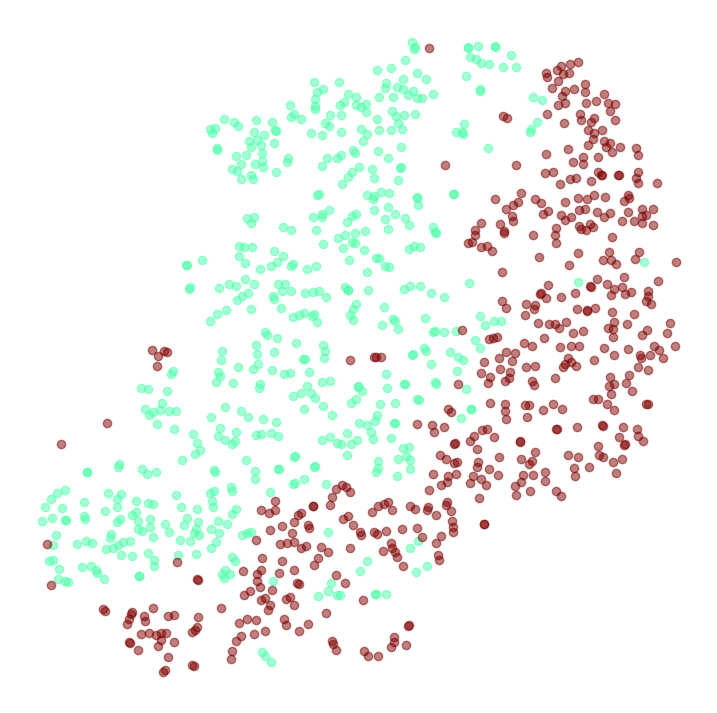

In [33]:
plt.figure(figsize=(9, 9))

for digit in ["4", "9"]:
    plt.scatter(
        X_subset_reduced[y_subset == digit, 0],
        X_subset_reduced[y_subset == digit, 1],
        c=[cmap(float(digit) / 9)],
        alpha=0.5,
    )
plt.axis("off")
plt.show()

That's much better, but there's still a bit of overlap. Perhaps some 4s do look like 9s and vice versa. It would be better if you can visualize some digits from each region of this plot.

Exercise: *Alternatively, you can replace each dot in the scatter plot with the corresponding instance’s class (a digit from 0 to 9), or even plot scaled-down versions of the digit images themselves (if you plot all digits the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance).*

In the following code cell, I create a `plot_digit()` function that will dram a scatter plot (similar to the above scatter plot) plus write colored digits, with a minimum distance guaranteed between these digits. If the digits images are provided, they are plotted instead.

This implementation was inspired by one of Scikit-learn's example ([plot_embedding](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html), based on a different digits dataset).

In [34]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage


def plot_digits(X, y, min_distance=0.04, images=None, figsize=(13, 10)):
    plt.figure(figsize=figsize)
    # Now, let's scale the numbers down so they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # We now create a list of coordinates of all digits plotted so far
    # We pretend that one is already plotted so far away at the start, to
    # avoid the np.linalg.norm() function throw a TypeError, as it expects an array-like input.
    plotted_digits = np.array([[10.0, 10.0]])
    cmap = plt.cm.jet
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(
            X_normalized[y == digit, 0],
            X_normalized[y == digit, 1],
            c=[cmap(float(digit) / 9)],
            alpha=0.5,
        )
    plt.axis("off")
    ax = plt.gca()  # get current axes
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(plotted_digits - image_coord, axis=1).min()
        if closest_distance > min_distance:
            plotted_digits = np.r_[plotted_digits, [image_coord]]
            if images is None:
                plt.text(
                    image_coord[0],
                    image_coord[1],
                    str(int(y[index])),
                    color=cmap(float(y[index]) / 9),
                    fontdict={"weight": "bold", "size": 16},
                )
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(
                    OffsetImage(image, cmap="binary"), image_coord
                )
                ax.add_artist(imagebox)

Let's give it a try! First, we plot colored digits (not images), for all 5,000 images.

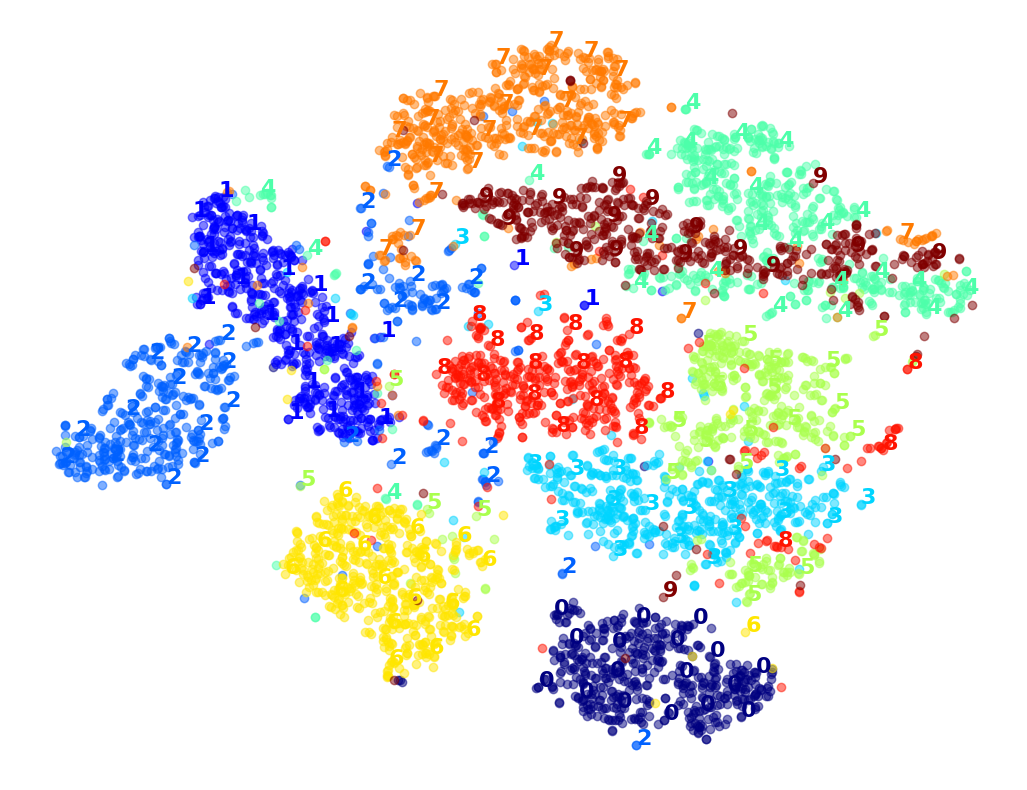

In [35]:
plot_digits(X_reduced, y_sample)

That's okay, but not so beautiful. Let's try with the digit images.

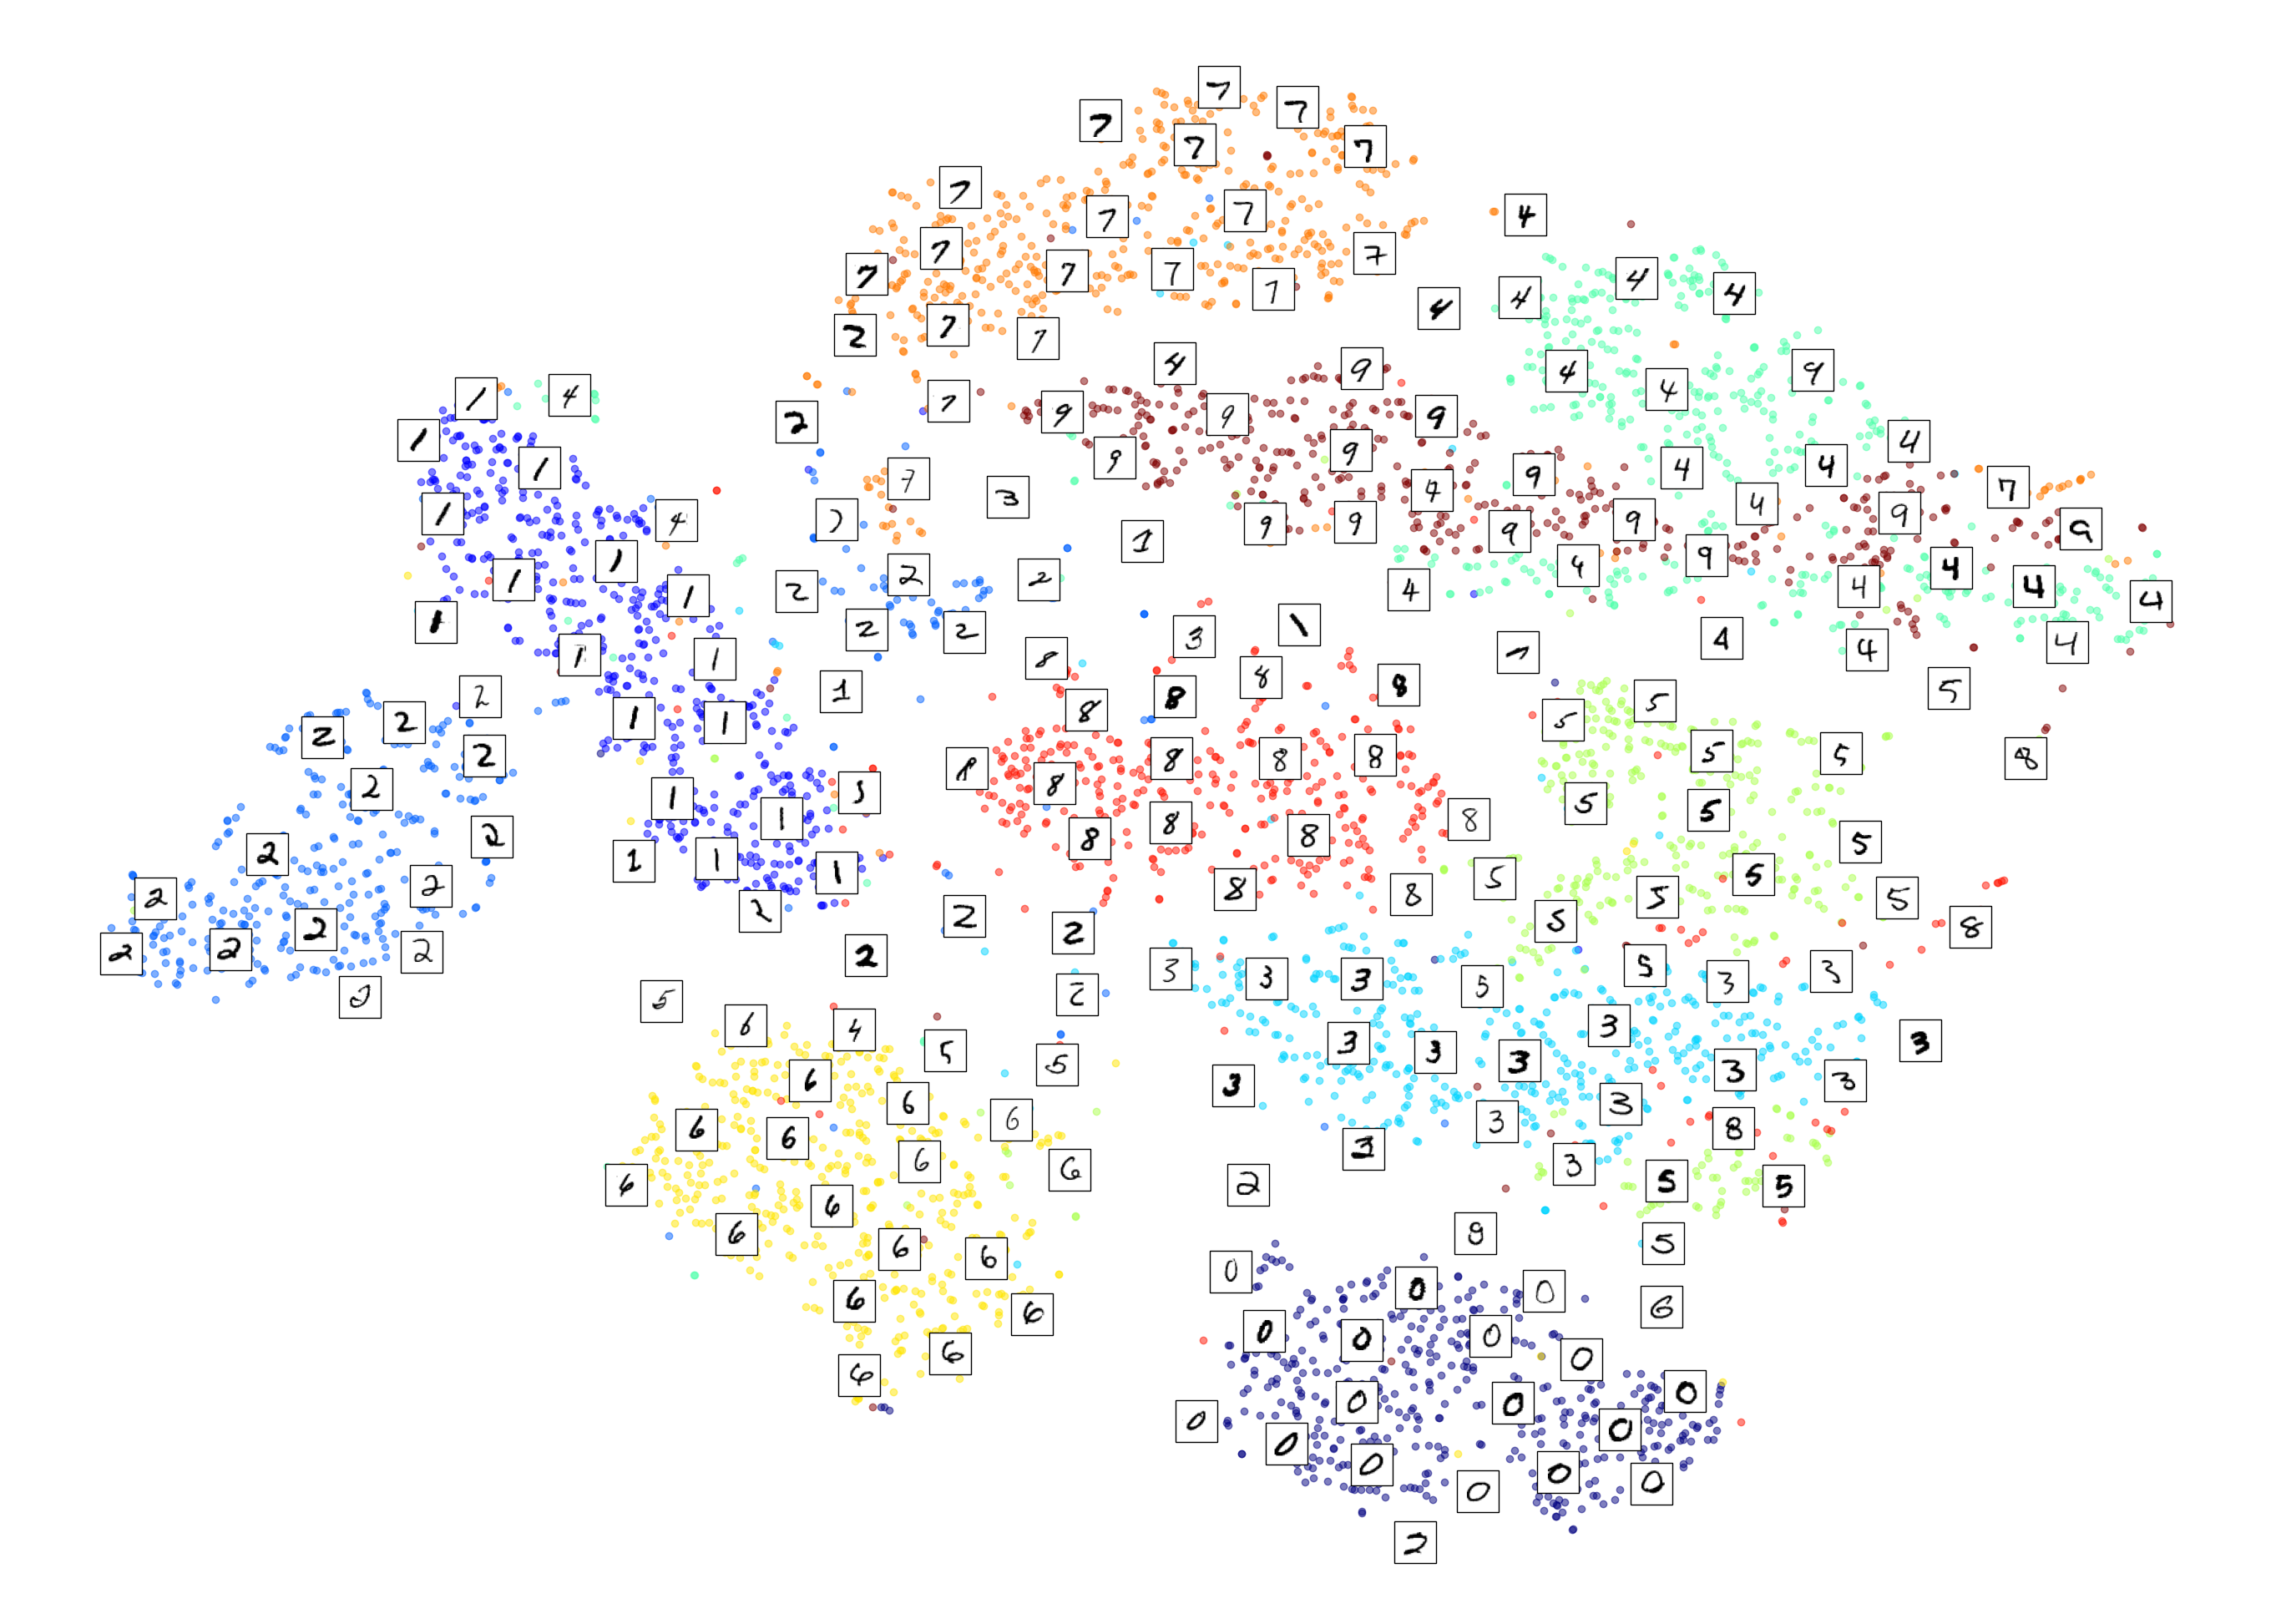

In [36]:
plot_digits(X_reduced, y_sample, images=X_sample, figsize=(35, 25))

Now we're talking! Let's move our focus to 4s and 9s.

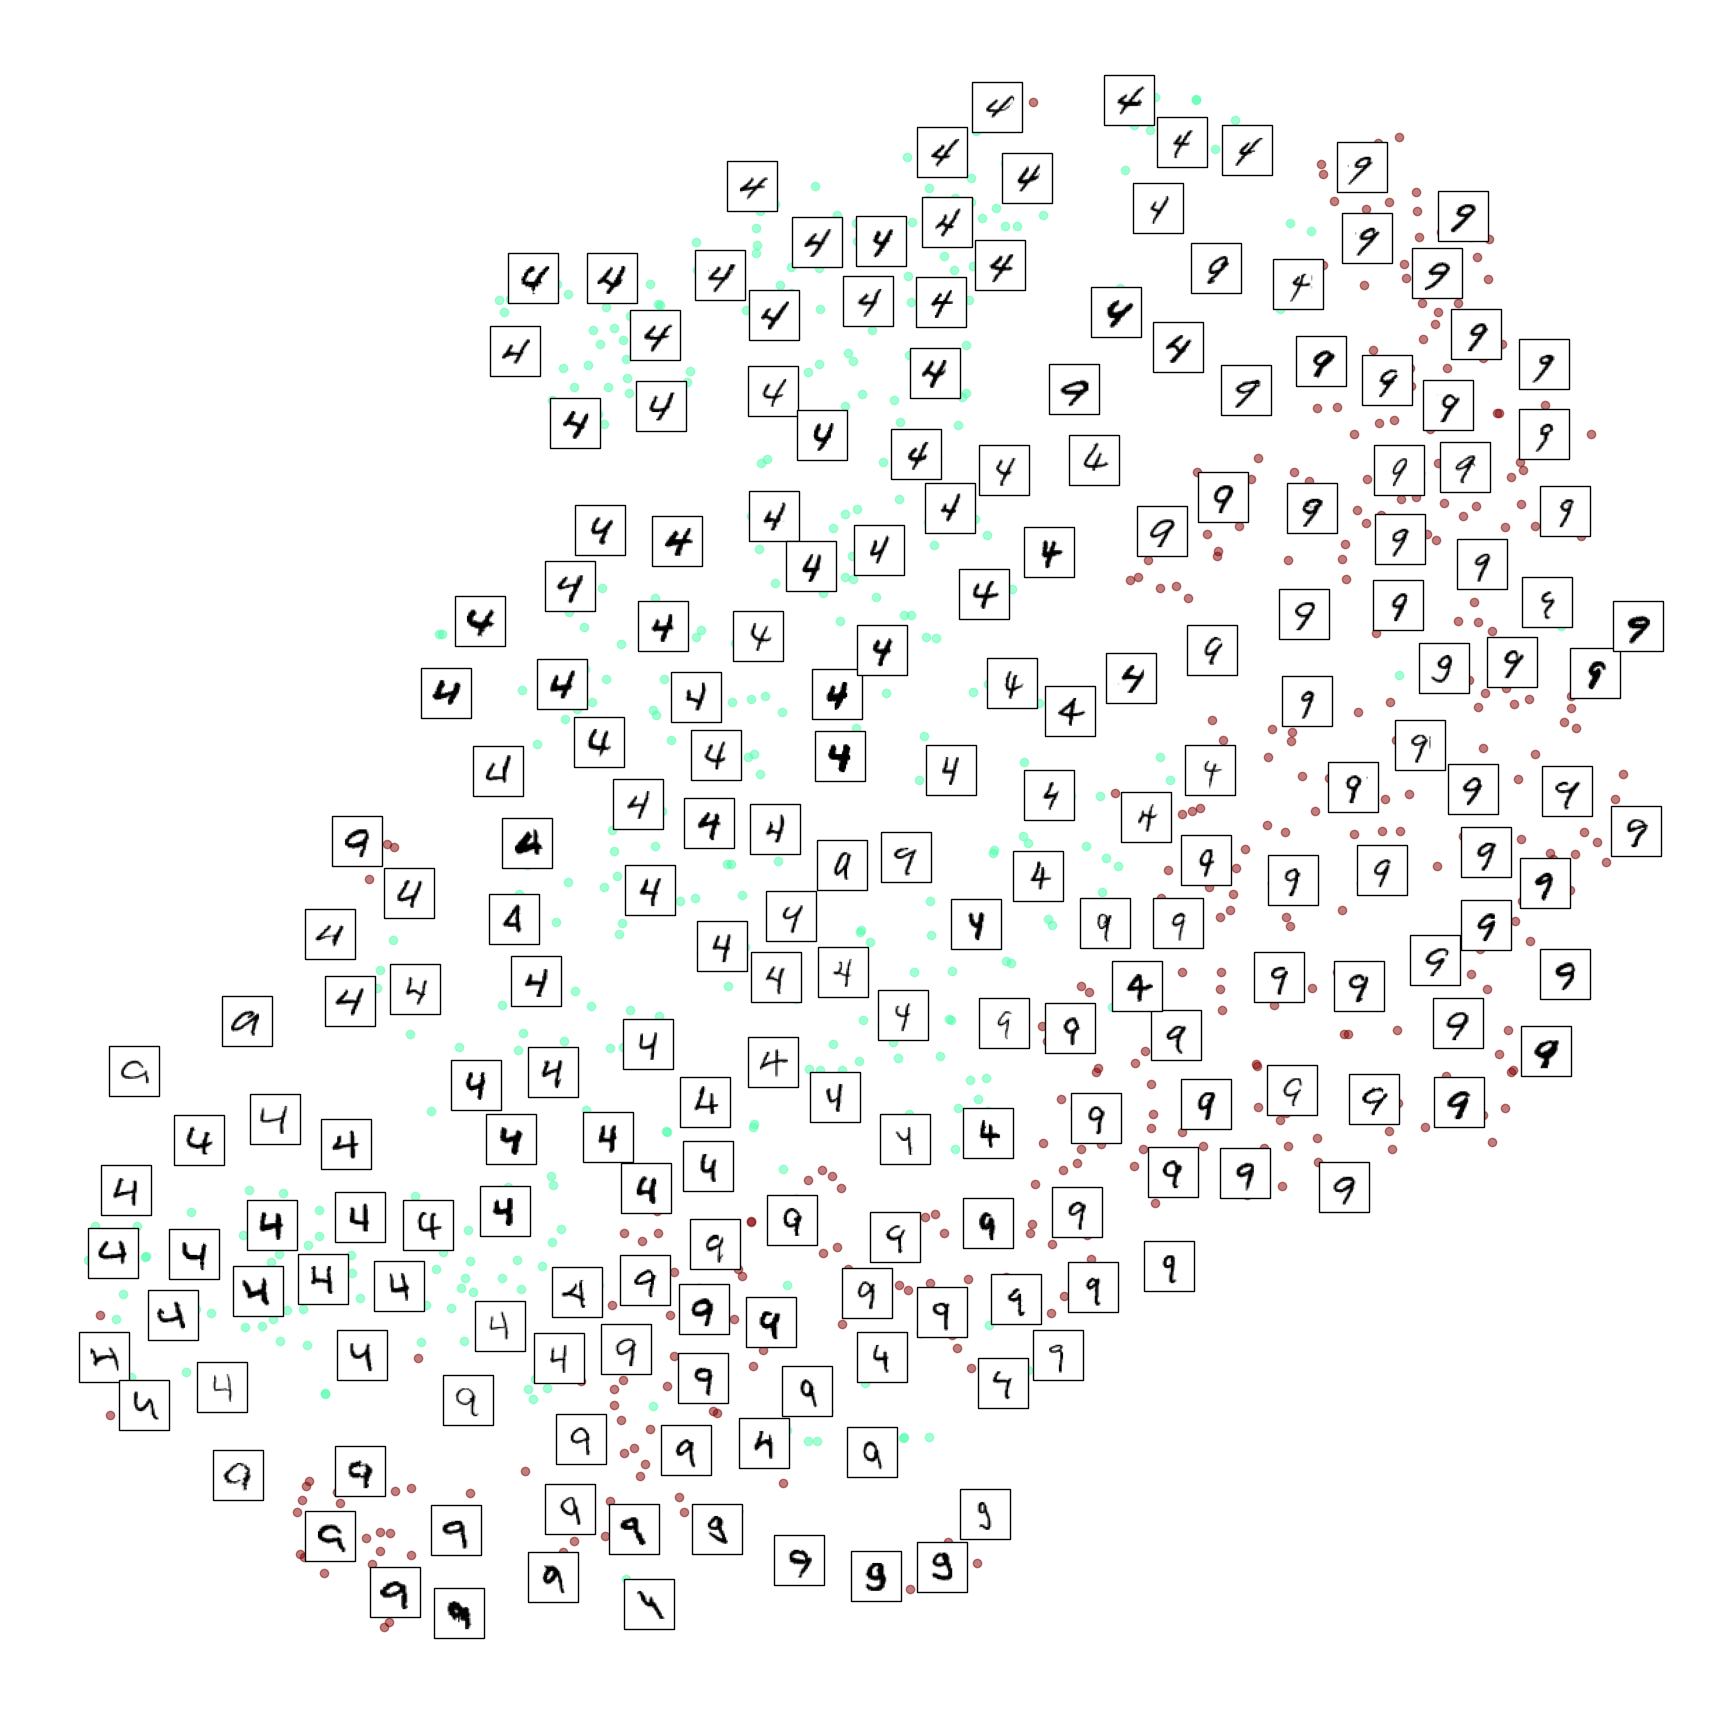

In [37]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

Notice how similar-looking 4s are grouped together. For example, the 4s get more and more inclined, as you approach the top of the plot. The inclined 9s are also closer to the top. Some 4s do look like 9s, and vice versa.

Exercise: *Try using other dimensionality reduction algorithms, such as PCA, LLE, or MDS, and compare the resulting visualizations.*

Let's start with PCA. We will also measure how long it takes.

CPU times: user 1.46 s, sys: 1.71 s, total: 3.17 s
Wall time: 374 ms


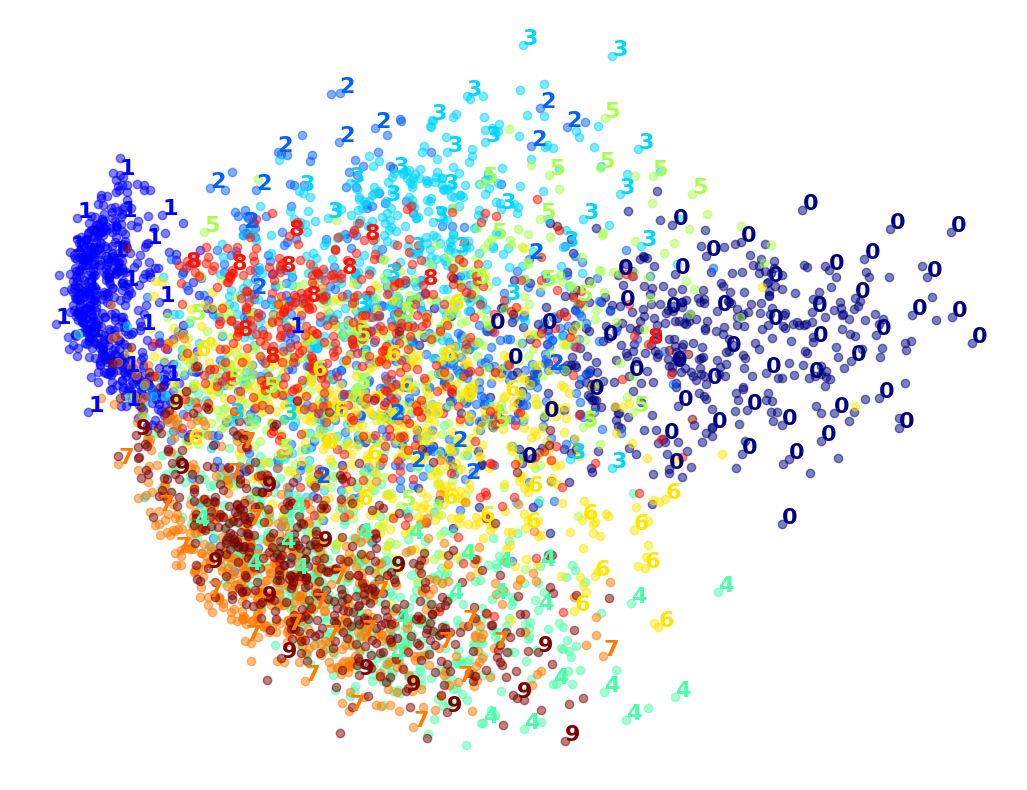

In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
%time X_pca_reduced = pca.fit_transform(X_sample)
plot_digits(X_pca_reduced, y_sample)
plt.show()

Well done PCA! Its speed is good. However, even if we see some clusters, there're just too much overlap. Let's try LLE.

CPU times: user 39.9 s, sys: 1min, total: 1min 40s
Wall time: 9.97 s


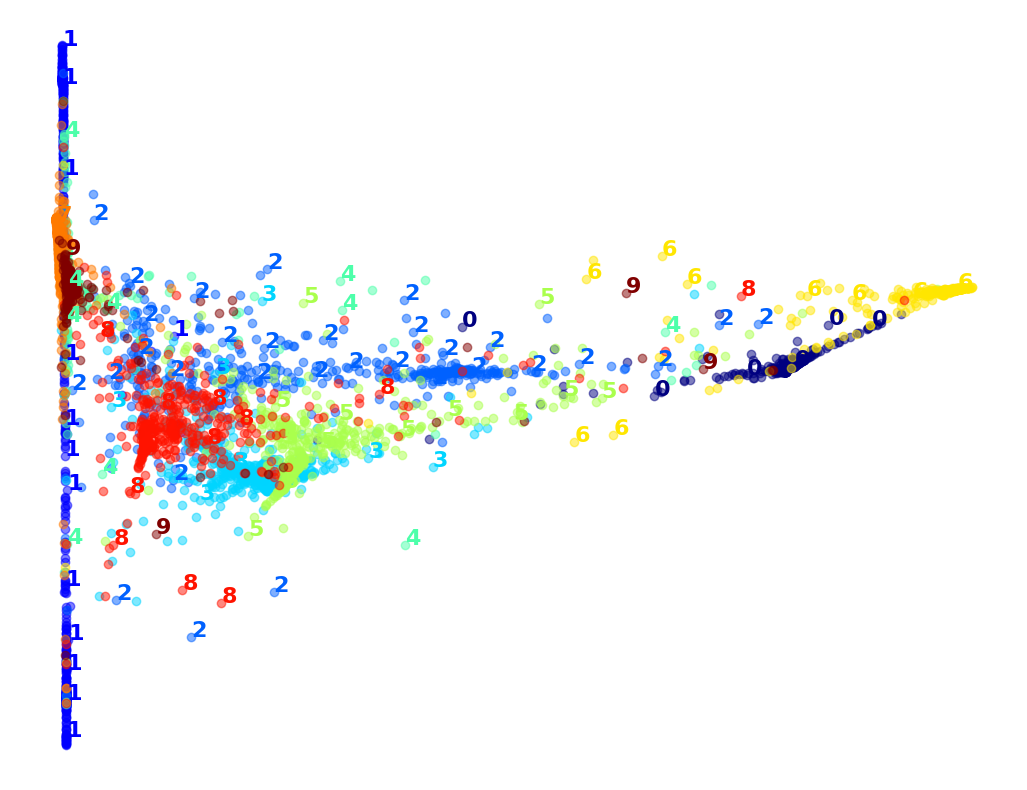

In [40]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, random_state=42)
%time X_lle_reduced = lle.fit_transform(X_sample)
plot_digits(X_lle_reduced, y_sample)

LLE took more time, and the result is not good at all. Let's see if we apply PCA beforehand to only preserving 95% of the variance, will the result be any better?

CPU times: user 36.2 s, sys: 48.2 s, total: 1min 24s
Wall time: 8.64 s


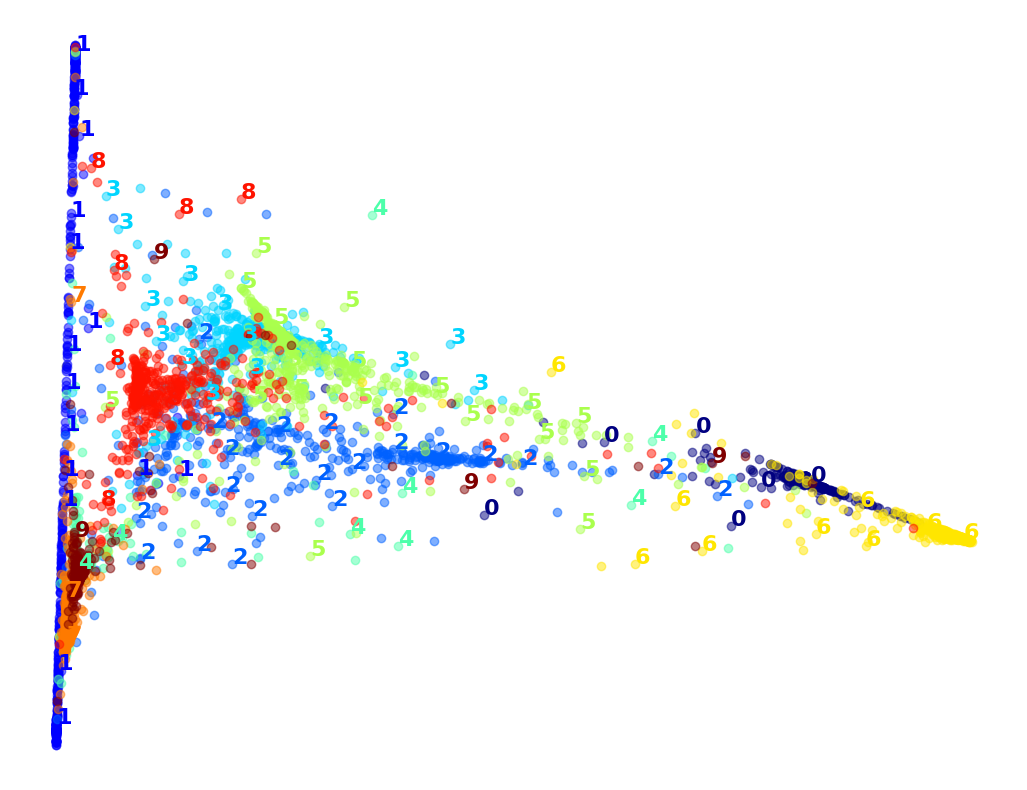

In [42]:
from sklearn.pipeline import make_pipeline

pca_lle = make_pipeline(PCA(n_components=0.95), LocallyLinearEmbedding(n_components=2, random_state=42))
%time X_pca_lle_reduced = pca_lle.fit_transform(X_sample)
plot_digits(X_pca_lle_reduced, y_sample)
plt.show()

The result is just as bad, but the training was speeded up a bit.

Let's try LDA.

CPU times: user 12.4 s, sys: 15.2 s, total: 27.6 s
Wall time: 3.18 s


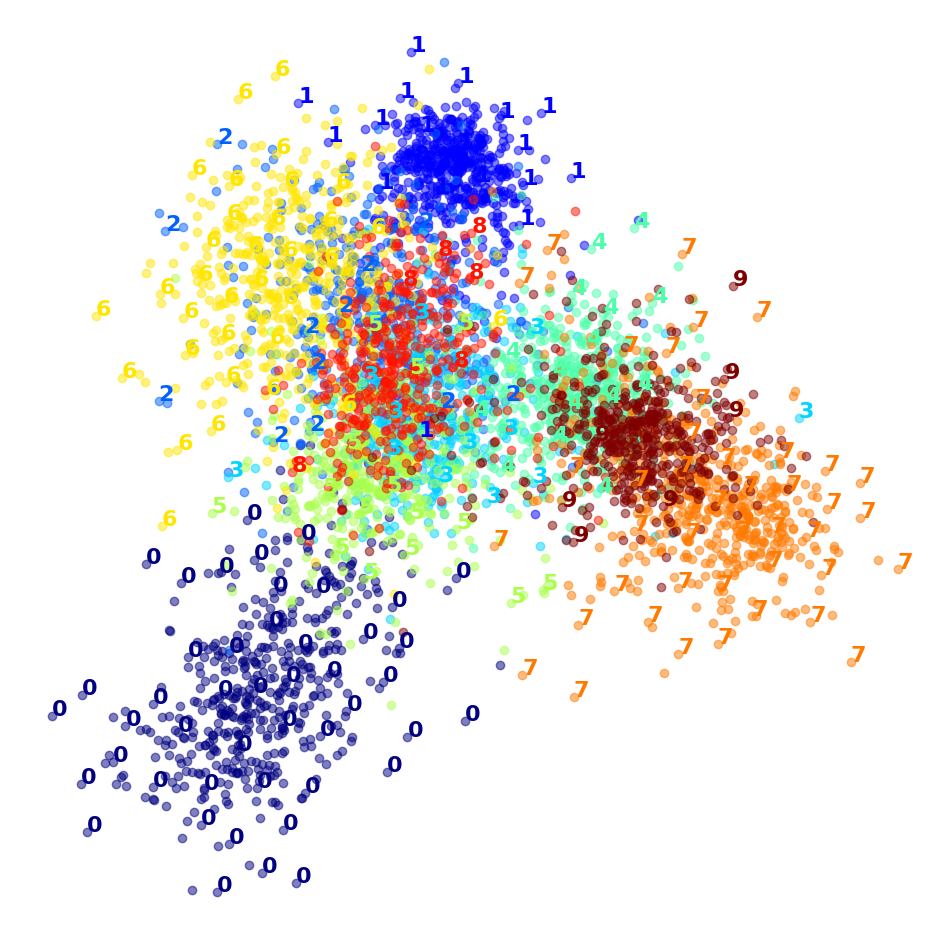

In [45]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
%time X_lda_reduced = lda.fit_transform(X_sample, y_sample)
plot_digits(X_lda_reduced, y_sample, figsize=(12, 12))
plt.show()

LDA is fast, and looks nice at a glance, but if you concentrate a bit, you then realize that several clusters overlap severely.

Now, we try MDS.

**Warning:** The following code cell will take about 10-30 minutes, depends on your hardware. 

I add `n_jobs=-1`, which can speed up training but overheat your hardware, so if you have plenty of time, remove that.

CPU times: user 11.6 s, sys: 7.23 s, total: 18.8 s
Wall time: 11min 59s


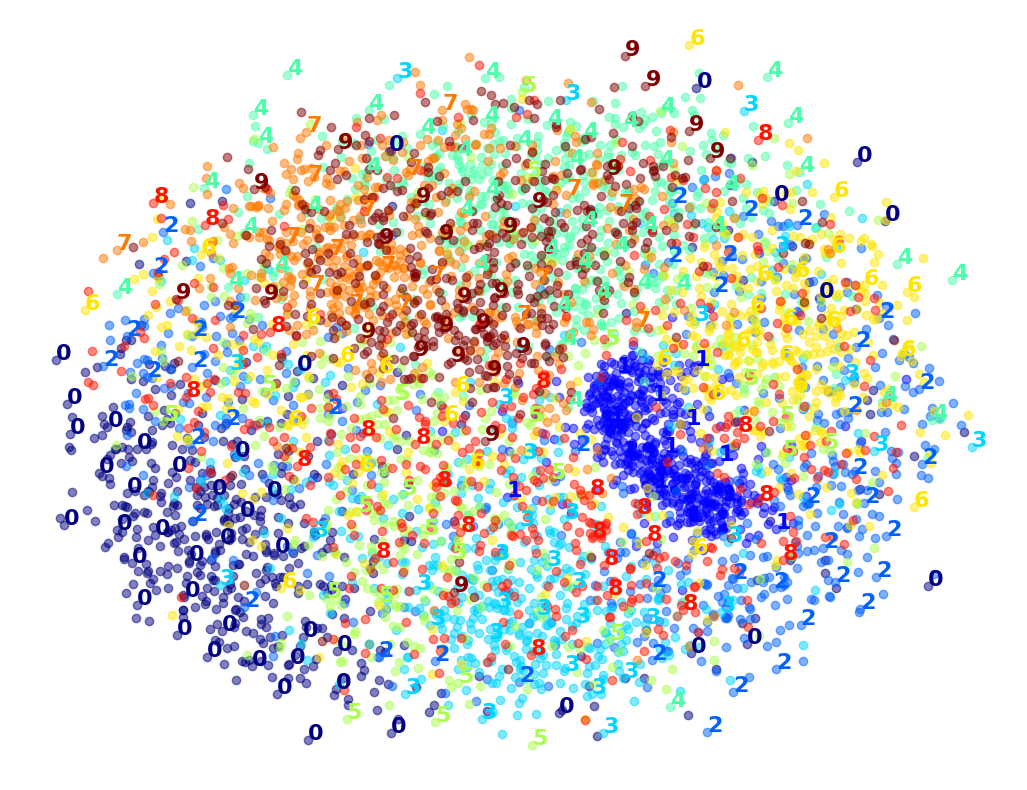

In [46]:
from sklearn.manifold import MDS

%time X_mds_reduced = MDS(n_components=2, normalized_stress=False, n_jobs=-1, random_state=42).fit_transform(X_sample)
plot_digits(X_mds_reduced, y_sample)
plt.show()

Nah. It looks bad, as all cluster overlap onto each other. It also takes too long to run, compare to other algorithms. Let try with PCA first to see if it will be any faster or better?

**Warning:** The following code cell will take about 10-30 minutes, depends on your hardware. 

I add `n_jobs=-1`, which can speed up training but overheat your hardware, so if you have plenty of time, remove that.

CPU times: user 20.4 s, sys: 20.1 s, total: 40.4 s
Wall time: 11min 15s


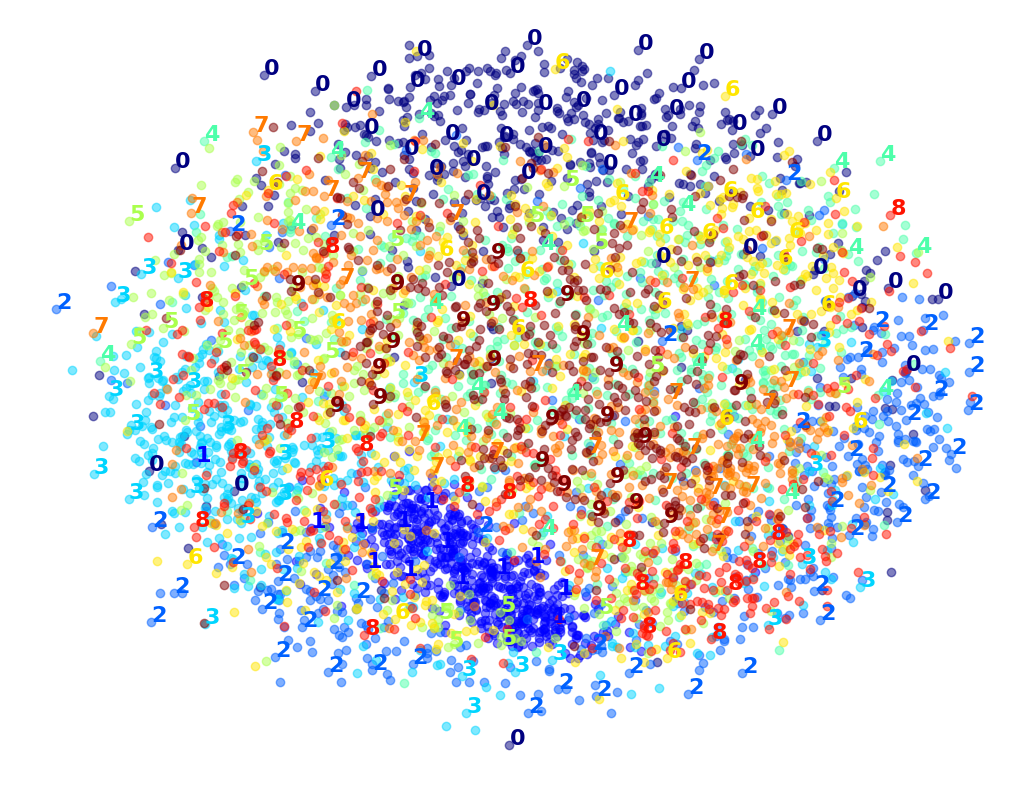

In [47]:
pca_mds = make_pipeline(
    PCA(n_components=0.95),
    MDS(n_components=2, normalized_stress=False, n_jobs=-1, random_state=42),
)

%time X_pca_mds_reduced = pca_mds.fit_transform(X_sample)
plot_digits(X_pca_mds_reduced, y_sample)
plt.show()

Same result, and not any faster: PCA didn't help in this case.

Well, it's pretty clear that t-SNE won this little competition. In fact, t-SNE is recommended when you want to visualize data on a 2D manner. A more detailed guide to t-SNE can be found in [Scikit-learn](https://distill.pub/2016/misread-tsne/).